### 分区

In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray
from rasterio import features
from shapely.geometry import mapping
# Load WWF ecoregions
eco_gdf = gpd.read_file(r"D:\Edge_download\official\wwf_terr_ecos.shp")

# Define regions based on ECO_NAME
region1 = eco_gdf[eco_gdf['ECO_NAME'].isin([
    'Pontic steppe', 'Kazakh steppe', 'East European forest steppe',
    'Balkan mixed forests', 'Northern Anatolian conifer and deciduous forests',
    'Central Anatolian steppe and woodlands', 'Anatolian conifer and deciduous mixed forests'])]

region2 = eco_gdf[eco_gdf['ECO_NAME'] == 'Sahelian Acacia savanna']

region3 = eco_gdf[eco_gdf['ECO_NAME'].isin([
    'Jian Nan subtropical evergreen forests', 'Changjiang Plain evergreen forests',
    'Guizhou Plateau broadleaf and mixed forests'])]

region4 = eco_gdf[eco_gdf['ECO_NAME'].isin([
    'Mongolian-Manchurian grassland', 'Central China loess plateau mixed forests',
    'Ordos Plateau steppe', 'Northeast China Plain deciduous forests',
    'Huang He Plain mixed forests'])]
region5 = eco_gdf[eco_gdf['ECO_NAME'].isin([
    'Northern short grasslands','Western short grasslands','Central and Southern mixed grasslands'])]
# Load referenceRegions
ref_gdf = gpd.read_file(r"D:\Edge_download\referenceRegions\referenceRegions.shp")

# Select specific NAME values
ref_region5 = ref_gdf[ref_gdf['NAME'].isin([
    'Southern Africa [SAF:17]'])]
ref_region6 = ref_gdf[ref_gdf['NAME'].isin([ 'Central America/Mexico [CAM:6]',])]
ref_region7 = ref_gdf[ref_gdf['NAME'].isin([
    'North-East Brazil [NEB:8]'])]
ref_region8 = ref_gdf[ref_gdf['NAME'].isin([ 'South Asia [SAS:23]'])]
ref_region9 = ref_gdf[ref_gdf['NAME'].isin([ 'Southeast Asia [SEA:24]'])]

In [4]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
crop_prob=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_mai_ssp585_default.nc").spei_to_yield_pval
# 确认crop_prob只包含lat/lon两个维度
lat = crop_prob['lat'].values
lon = crop_prob['lon'].values

region_mask = xr.full_like(crop_prob, fill_value=0, dtype=int)

lon2d, lat2d = np.meshgrid(lon, lat)
points = gpd.GeoSeries(gpd.points_from_xy(lon2d.ravel(), lat2d.ravel()), crs="EPSG:4326")

def to_crs(gdf, crs="EPSG:4326"):
    if gdf.crs != crs:
        return gdf.to_crs(crs)
    return gdf

region_geoms = [
    to_crs(region1).unary_union,
    to_crs(region2).unary_union,
    to_crs(region3).unary_union,
    to_crs(region4).unary_union,
    to_crs(region5).unary_union,
    to_crs(ref_region5).unary_union,
    to_crs(ref_region6).unary_union,
    to_crs(ref_region7).unary_union,
    to_crs(ref_region8).unary_union,
    to_crs(ref_region9).unary_union,
]
for idx, geom in enumerate(region_geoms, start=1):
    contains = points.within(geom)
    mask = contains.values.reshape(lat2d.shape)
    region_mask.values[mask] = idx

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2628\1649991231.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  to_crs(region1).unary_union,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2628\1649991231.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  to_crs(region2).unary_union,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2628\1649991231.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  to_crs(region3).unary_union,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2628\1649991231.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  to_crs(region4).unary_union,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2628\1649991231.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method inste

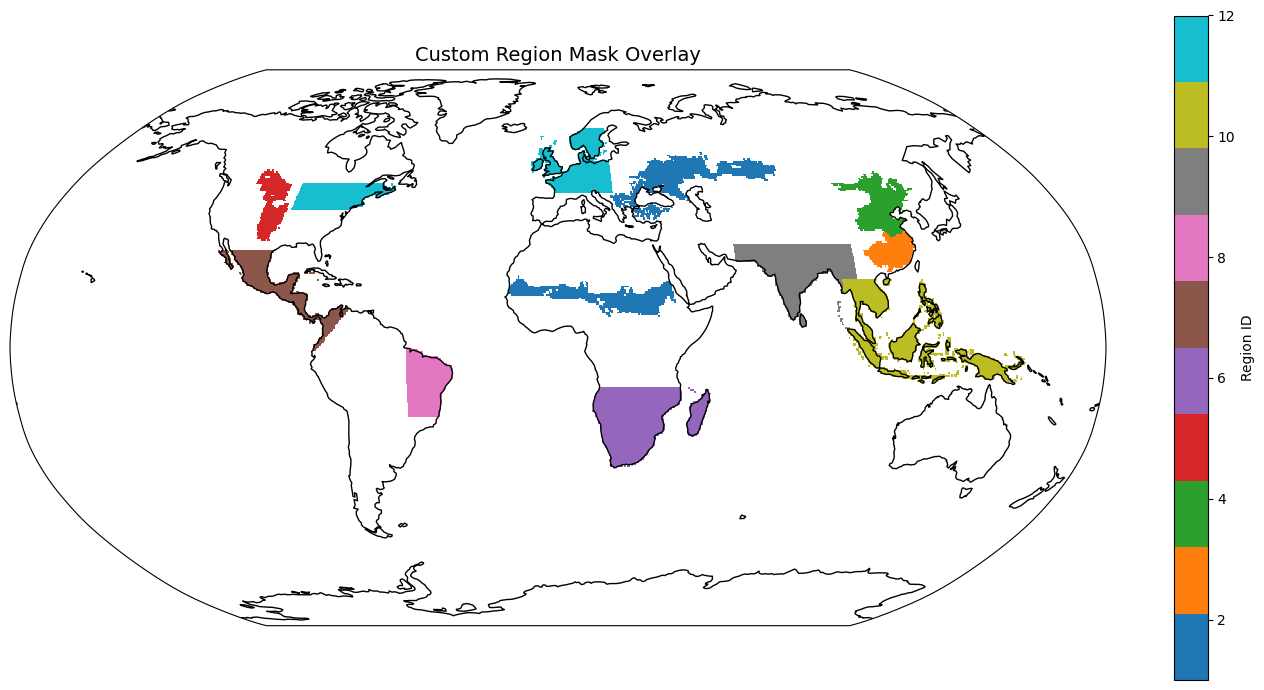

In [5]:
new_region_id = 11
lat_min, lat_max = 40, 48
lon_min, lon_max = -95, -60
new_region_mask = ( (lat2d >= lat_min) & (lat2d <= lat_max) & 
                    (lon2d >= lon_min) & (lon2d <= lon_max) )
region_mask.values[new_region_mask] = new_region_id

new_region_id = 12
lat_min, lat_max = 45, 65
lon_min, lon_max = -14, 20
new_region_mask = ( (lat2d >= lat_min) & (lat2d <= lat_max) & 
                    (lon2d >= lon_min) & (lon2d <= lon_max) )
region_mask.values[new_region_mask] = new_region_id
region_mask=region_mask.where(region_mask!=0)
cell=xr.open_dataset(r'D:\Edge_download\cellarea.nc').cellarea30min
region_mask=region_mask.where(cell>0)
region_mask=region_mask.rename('classification')
region_mask.to_netcdf(r"D:\AAUDE\paper\paper8\data\classification.nc")
# 更新名称字典
# region_names[new_region_id] = '美国中北部农业区'  # 名称你可以自行修改
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': ccrs.Robinson()})
region_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab10',
                 add_colorbar=True, cbar_kwargs={'label': 'Region ID'})

ax.set_title("Custom Region Mask Overlay", fontsize=14)
ax.coastlines()
ax.set_global()
plt.tight_layout()
plt.show()

In [7]:
import xarray as xr
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape
import numpy as np

# 假设 region_mask 是一个 2D DataArray，纬度在第一个维度
# 例如 region_mask = xr.open_dataarray('region_mask.nc')

# Step 1: 填充为整数类型，准备掩膜数据
mask_data = region_mask.values
mask_data = np.where(mask_data == -2147483648, np.nan, mask_data)

transform = rasterio.transform.from_bounds(
    region_mask.lon.min().item(), region_mask.lat.min().item(),
    region_mask.lon.max().item(), region_mask.lat.max().item(),
    region_mask.sizes['lon'], region_mask.sizes['lat']
)

# Step 2: 生成矢量 polygon，注意坐标顺序：纬度在 Y， 经度在 X
shapes = rasterio.features.shapes(mask_data, transform=transform, mask=~np.isnan(mask_data))

# Step 3: 转换为 GeoDataFrame
records = []
for geom, value in shapes:
    if value == 0:  # 排除值为0的背景部分
        continue
    records.append({'geometry': shape(geom), 'region': int(value)})

gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")

# Step 4: 保存为 Shapefile
gdf.to_file("region_mask_regions.shp")


In [1]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
exps=['default','2015co2']
# var='ssi'
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for exp in exps:
    for ssp in ssps:
        if exp =='2015co2' and ssp=='historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_wwh_{ssp}_{exp}.nc')['swd'].where(area_wwh>0).fillna(0)+\
                    xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_swh_{ssp}_{exp}.nc')['swd'].where(area_swh>0).fillna(0)
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[exp][ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[exp][ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[exp][ssp][crop]['ssi'] = ssi.where(ssi!=0)
                    result_dict1[exp][ssp][crop]['swd'] = swd[:-1].where(swd[:-1]!=0)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                # try:
                fp = r'D:\AAUDE\paper\paper8\data\result2'
                area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_{crop}_{ssp}_{exp}.nc')['swd'].where(area>0)
                ssi_data=change(ssi_data,yied,ssp)
                spei_data=change(spei_data,yied,ssp)
                result_dict1[exp][ssp][crop]['yield'] =yied.where(area>0)
                result_dict1[exp][ssp][crop]['spei'] = spei_data.where(area>0)
                result_dict1[exp][ssp][crop]['ssi'] = ssi_data.where(area>0)
                result_dict1[exp][ssp][crop]['swd'] = swd[:-1].where(swd[:-1]!=0)

In [3]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
exps=['default','2015co2']
for exp in exps:
    for ssp in ssps:
        if exp == '2015co2' and ssp == 'historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'exptct_yield_wwh_{ssp}_{exp}_smooth20.nc'))[f'yield-wwh-noirr'].fillna(0)+\
                 xr.open_dataset(join(fp, f'exptct_yield_swh_{ssp}_{exp}_smooth20.nc'))[f'yield-swh-noirr'].fillna(0)
                
                result_dict2[exp][ssp][crop]['expect_yield'] =yied.where(yied!=0)
    
            else:
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'exptct_yield_{crop}_{ssp}_{exp}_smooth20.nc'))[f'yield-{crop}-noirr']
                result_dict2[exp][ssp][crop]['expect_yield'] =yied

In [120]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

crops = ['mai','soy','whe']
ssps = ['historical', 'ssp126', 'ssp585']
exps = ['default', '2015co2']

def generate_results(result_dict1, result_dict2):
    results = {}
    for exp in exps:
        results[exp] = {}
        for ssp in tqdm(ssps, desc='Processing SSPs'):
            if exp == '2015co2' and ssp == 'historical':
                continue
            results[exp][ssp] = {}
            idx =-2  # 时间长度
            
            for crop in tqdm(crops, desc='Processing Crops', leave=False):
                area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                # 加载主导类型
                dominant_type = xr.open_dataset(
                    rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}_default.nc"
                ).spei_to_yield_strength
                
                # 产量数据
                expect_yield = result_dict2[exp][ssp][crop]['expect_yield'][-idx-1:-1]
                
                yied = result_dict1[exp][ssp][crop]['yield'][-idx:]
                yied = yied.where(yied > 0)
                
                yield_loss = (yied - expect_yield) / expect_yield*100
                
                # 干旱指数
                ssi = result_dict1[exp][ssp][crop]['ssi'][-idx:]
                swd = (result_dict1[exp][ssp][crop]['swd'][-idx:]-result_dict1[exp][ssp][crop]['swd'][:10].mean(dim='time'))/result_dict1[exp][ssp][crop]['swd'][:10].mean(dim='time')
                # swd = (result_dict1[exp][ssp][crop]['swd'][-idx:]-result_dict2[exp][ssp][crop]['swd'][-idx:])/result_dict2[exp][ssp][crop]['swd'][-idx:]
                
                # 筛选条件
                mask = (abs(yield_loss) < 200) #& ((dominant_type == 0) | (dominant_type == 1))
                yield_loss = yield_loss.where(mask)
                ssi = ssi.where(mask)
                swd = swd.where(mask)
                
                # 保存到 results
                results[exp][ssp][crop] = {
                    'yield_loss': yield_loss[-30:],
                    'ssi': ssi[-30:],
                    'swd': swd[-30:],
                    'production_loss': (yied[-30:] - expect_yield[-30:])*area,
                    'production': (yied[-30:])*area
                }
    return results

# 调用示例
results = generate_results(result_dict1, result_dict2)


Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

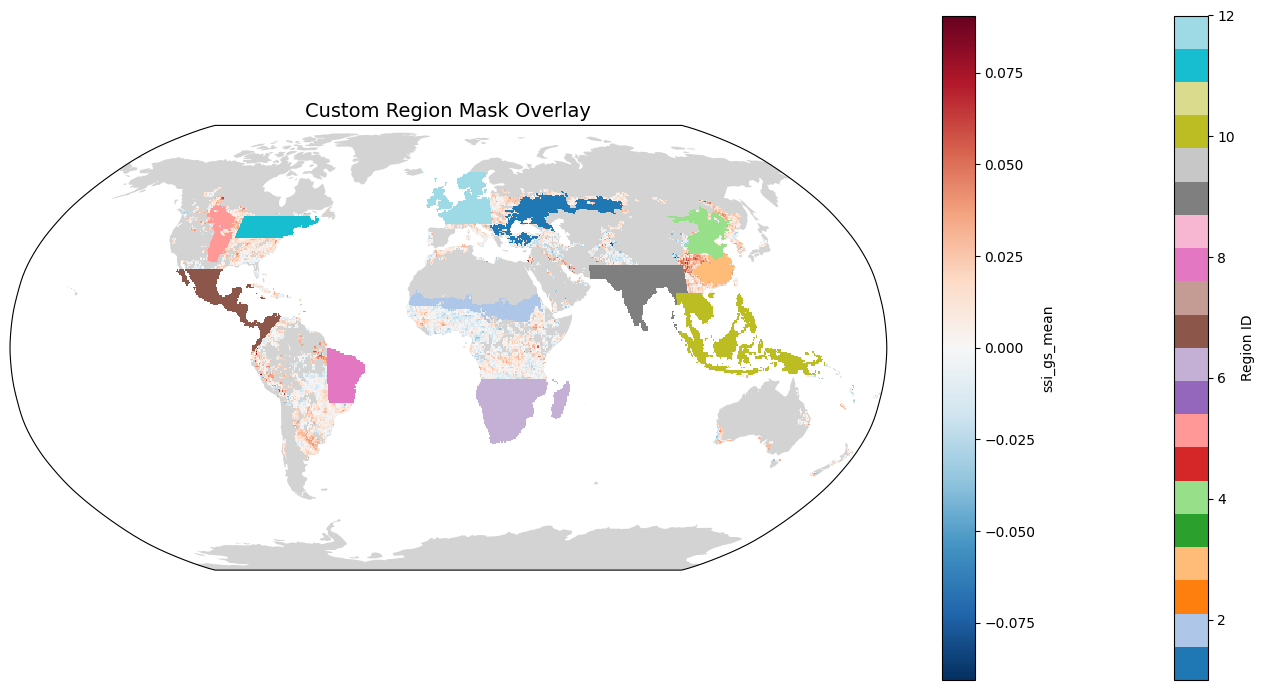

In [21]:
import matplotlib as mpl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
region_mask=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\classification.nc").classification

fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
# region_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20',
#                  add_colorbar=True, cbar_kwargs={'label': 'Region ID'})
result_dict1['default']['historical']['mai']['ssi'].mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(),zorder=0)
ax.set_title("Custom Region Mask Overlay", fontsize=14)
# ax.coastlines()
ax.set_global()
plt.tight_layout()
plt.show()

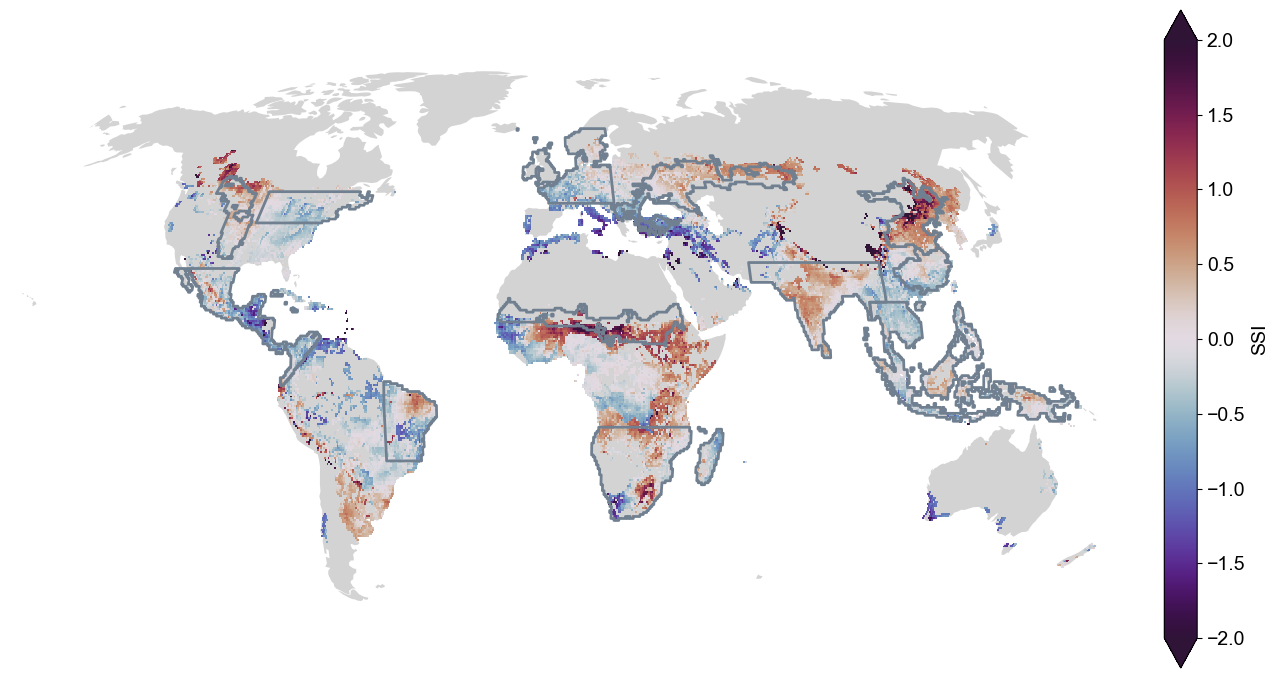

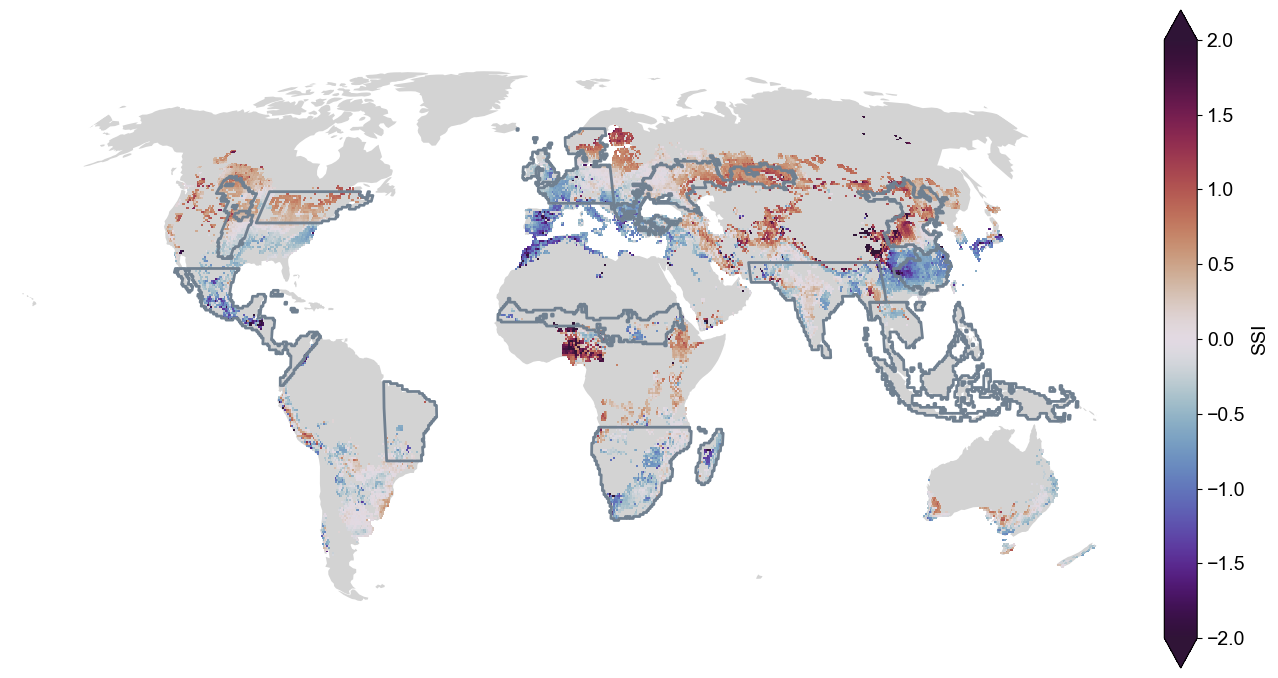

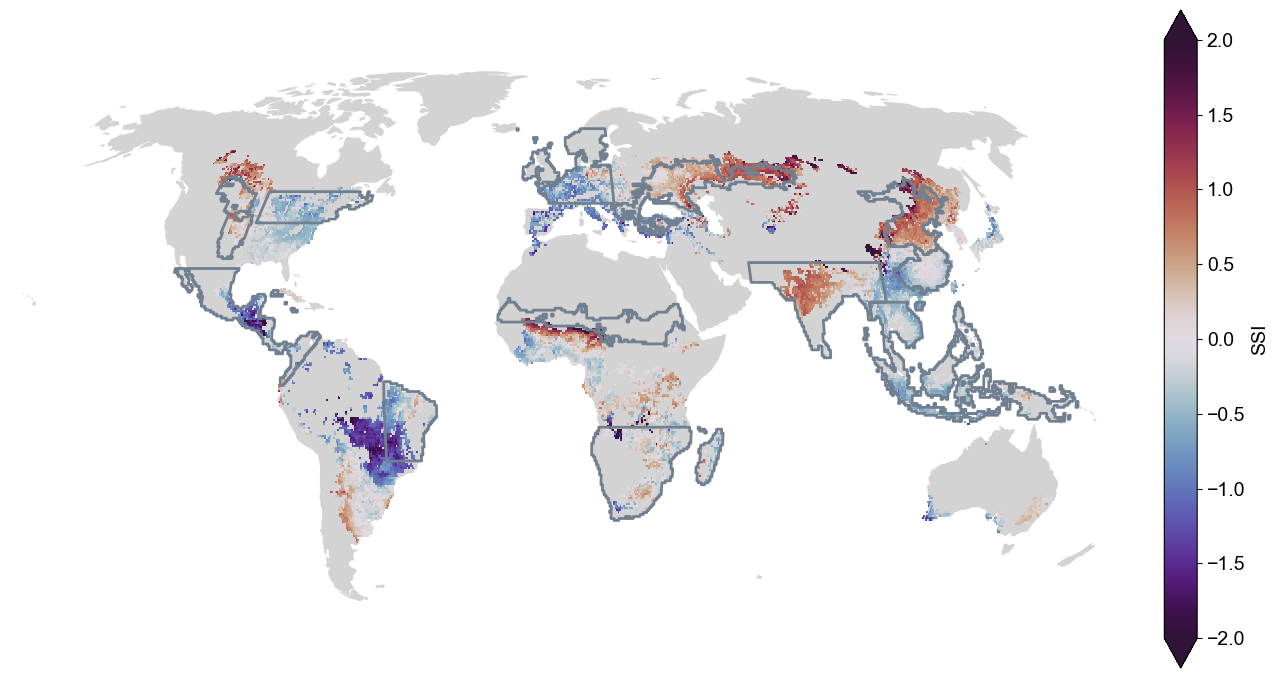

In [108]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr

# 读取 shapefile
regions = gpd.read_file("region_mask_regions.shp")
for crop in crops:
    fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': ccrs.Robinson()})
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 14
    # 绘制栅格数据
    ssi_mean = result_dict1['default']['ssp585'][crop]['ssi'][-30:].mean(dim='time')
    ssi_mean.plot(ax=ax, transform=ccrs.PlateCarree(), zorder=0, cmap='twilight_shifted', add_colorbar=True,
                  vmax=2, vmin=-2,
                  cbar_kwargs={'label': 'SSI'})
    
    # 添加陆地背景
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=-1)
    
    # 绘制区域边界
    regions.plot(ax=ax, facecolor='none', edgecolor='slategray', linewidth=2, transform=ccrs.PlateCarree(), zorder=1)
    
    # # 在每个区域中心添加标签
    # for idx, row in regions.iterrows():
    #     # 获取区域中心坐标
    #     centroid = row.geometry.centroid
    #     ax.text(centroid.x, centroid.y, str(row['region']),  # 假设列名为 'region'，你改成你的字段名
    #             horizontalalignment='center',
    #             verticalalignment='center',
    #             fontsize=10,
    #             fontweight='bold',
    #             color='black',
    #             transform=ccrs.PlateCarree(),
    #             zorder=2)
    
    ax.set_global()
    ax.set_extent([-160, 160, -60, 90], crs=ccrs.PlateCarree())
    ax.spines['geo'].set_visible(False)
    plt.tight_layout()
    plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\region\{crop}_ssp585.pdf',format='pdf',bbox_inches='tight',dpi=300,)
    plt.show()

In [ ]:
region_mask=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\classification.nc").classification
for i in range(1,13):
    mask=region_mask==i
    results[exp][ssp][crop]['yield_loss']
    results[exp][ssp][crop]['ssi']
    results[exp][ssp][crop]['swd']

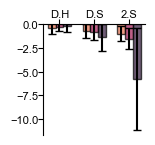

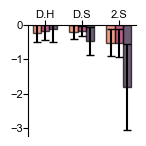

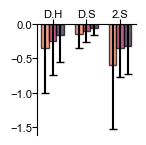

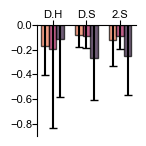

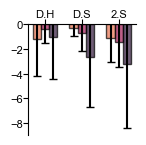

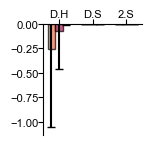

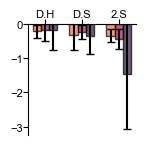

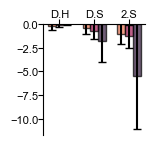

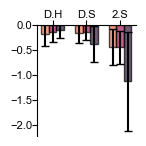

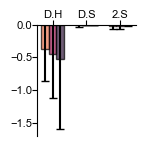

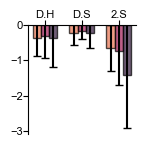

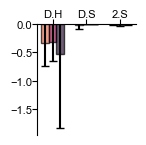

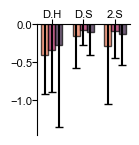

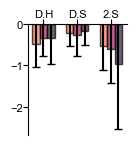

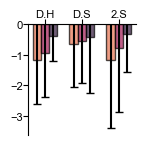

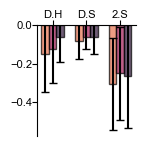

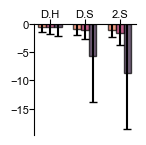

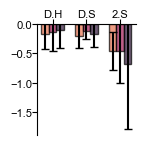

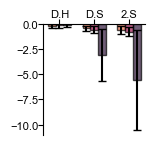

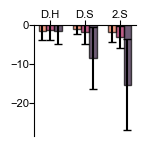

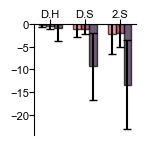

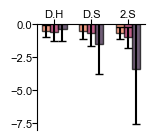

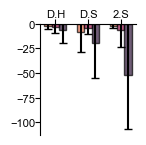

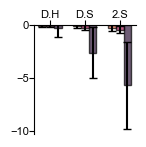

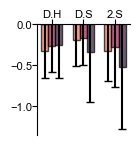

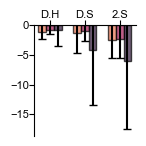

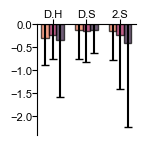

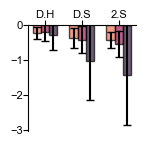

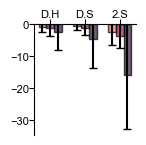

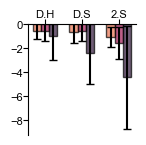

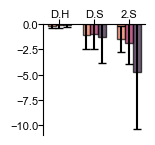

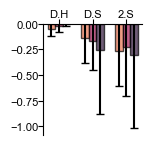

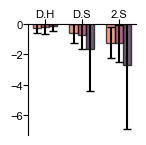

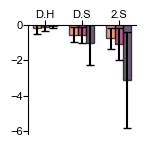

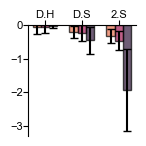

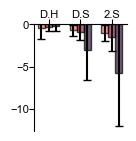

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import pandas as pd

# 设置全局样式
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8

# 干旱等级颜色和标签
severity_colors = ['#e7724f', '#a21a54', '#32183c']  # Mild, Moderate, Severe
severity_labels = ['Mild', 'Moderate', 'Severe']

# 加载区域掩码
region_mask = xr.open_dataset(r"D:\AAUDE\paper\paper8\data\classification.nc").classification

def plot_regional_yield_loss_bars(results, crops, regions=12):
    # 为每个区域创建图形
    for region in range(1, regions+1):
        mask = region_mask == region
        
        # 准备存储所有数据
        all_data = []
        
        # 定义要绘制的情景组合
        scenarios = [
            ('default', 'historical'),
            ('default', 'ssp585'),
            ('2015co2', 'ssp585')
        ]
        
        for crop in crops:
        # crop=crops[0]
            for exp, ssp in scenarios:
                try:
                    # 获取所有时间的数据
                    yield_loss = results[exp][ssp][crop]['yield_loss']
    
                    production_loss = results[exp][ssp][crop]['production_loss']
                    production = results[exp][ssp][crop]['production'].where(mask)
                    yield_loss=production_loss
                    
                    ssi = results[exp][ssp][crop]['ssi']
                    
                    # 应用区域掩码
                    yield_loss = yield_loss.where(mask)
                    ssi = ssi.where(mask)
             
                    # 计算各干旱等级下的产量损失 & (yield_loss < 0)
                    mild = yield_loss.where((ssi <= -0.42) & (ssi > -0.54)& (yield_loss < 0)).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    moderate = yield_loss.where((ssi <= -0.54) & (ssi > -0.69)& (yield_loss < 0)).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    severe = yield_loss.where((ssi <= -0.69)& (yield_loss < 0) ).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    
                    # 计算均值和标准差
                    for severity, data in zip(severity_labels, [mild, moderate, severe]):
                        valid_data = data.values[~np.isnan(data.values)]
                        if len(valid_data) > 0:
                            all_data.append({
                                'Region': region,
                                'Crop': crop,
                                'Scenario': f"{exp}_{ssp}",
                                'Severity': severity,
                                'Mean': np.mean(valid_data),
                                'sum': np.sum(valid_data),
                                'Std': np.std(valid_data),
                                'Count': len(valid_data)
                            })
                            
                except KeyError:
                    continue
        
        # 转换为DataFrame
        df = pd.DataFrame(all_data)
        
        if len(df) == 0:
            print(f"No data for region {region}, skipping...")
            continue
        
        # 为每种作物创建单独的图形
        for crop in df['Crop'].unique():
            fig, ax = plt.subplots(figsize=(1.5, 1.5))
            plt.subplots_adjust(left=0,    # 左边距 
               right=1,   # 右边距
               top=1,     # 上边距
               bottom=0) 
            # 筛选当前作物的数据
            crop_df = df[df['Crop'] == crop]
            
            # 设置x轴位置
            n_scenarios = len(crop_df['Scenario'].unique())
            bar_width = 0.2
            group_width = bar_width * len(severity_labels)
            spacing = 0.3  # 情景组之间的间距
            
            # 计算每个情景组的起始位置
            scenario_positions = np.arange(n_scenarios) * (group_width + spacing)
            
            # 为每个情景和干旱等级绘制柱状图
            for i, scenario in enumerate(crop_df['Scenario'].unique()):
                for j, severity in enumerate(severity_labels):
                    # 筛选数据
                    subset = crop_df[(crop_df['Scenario'] == scenario) & 
                                   (crop_df['Severity'] == severity)]
                    
                    if len(subset) == 0:
                        continue
                    
                    # 计算x位置
                    x = scenario_positions[i] + j * bar_width
                    
                    # 绘制柱状图和误差棒
                    bars = ax.bar(x, subset['Mean'], bar_width,
                                 color=severity_colors[j],
                                 label=severity if i == 0 else "",
                                 alpha=0.7,
                                 edgecolor='black')
                    
                    ax.errorbar(x, subset['Mean'], yerr=subset['Std'],
                               fmt='none', ecolor='black', capsize=3)
                    
                    # 添加数据标签
                    # ax.text(x, subset['Mean'].values[0] + 0.5, 
                    #        f"n={subset['Count'].values[0]}",
                    #        ha='center', va='bottom', fontsize=8)
            
            # 设置x轴标签和标题
            # scenario_labels = [f"{scenario.replace('_', chr(10))}" for scenario in crop_df['Scenario'].unique()]
            scenario_labels=['D.H','D.S','2.S']
            ax.set_xticks(scenario_positions + group_width/2 - bar_width/2)
            ax.set_xticklabels(scenario_labels)
            
            # ax.set_ylabel('Yield Loss (%/yr)')
            # ax.set_title(f'Region {region} - {crop} Yield Loss by Scenario and Drought Severity')
            
            # 添加图例
            # handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7) 
            #           for color in severity_colors]
            # ax.legend(handles, severity_labels, title='Drought Severity',
            #          loc='lower left', frameon=False)
            
            # 添加情景组之间的分隔线
            # for pos in scenario_positions + group_width:
            #     ax.axvline(x=pos - bar_width/2, color='gray', linestyle=':', alpha=0.5)
            
            # 美化图形
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.grid(axis='y', linestyle='--', alpha=0.3)
            ax.grid(False)
            ax.set_ylim(top=0)
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.xaxis.set_tick_params(pad=0)
            ax.yaxis.set_tick_params(pad=0)
            plt.tight_layout()
            plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\region\yield_loss_bars_region_{region}_{crop}.pdf', 
                       dpi=300, bbox_inches='tight')
            plt.show()

# 调用函数
crops = ['mai', 'whe', 'soy']
plot_regional_yield_loss_bars(results, crops, regions=12)

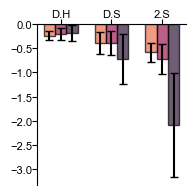

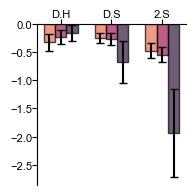

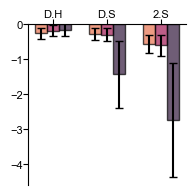

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import pandas as pd

# 设置全局样式
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8

# 干旱等级颜色和标签
severity_colors = ['#e7724f', '#a21a54', '#32183c']  # Mild, Moderate, Severe
severity_labels = ['Mild', 'Moderate', 'Severe']

# 加载区域掩码
region_mask = xr.open_dataset(r"D:\AAUDE\paper\paper8\data\classification.nc").classification

def plot_regional_yield_loss_bars(results, crops, regions=12):
    # 为每个区域创建图形
    # for region in range(1, regions+1):
    #     mask = region_mask == region
        
        # 准备存储所有数据
        all_data = []
        
        # 定义要绘制的情景组合
        scenarios = [
            ('default', 'historical'),
            ('default', 'ssp585'),
            ('2015co2', 'ssp585')
        ]
        
        for crop in crops:
        # crop=crops[0]
            for exp, ssp in scenarios:
                # try:
                    # 获取所有时间的数据
                    yield_loss = results[exp][ssp][crop]['yield_loss']
    
                    production_loss = results[exp][ssp][crop]['production_loss']
                    production = results[exp][ssp][crop]['production']
                    yield_loss=production_loss
                    
                    ssi = results[exp][ssp][crop]['ssi']
                    
                    # 应用区域掩码
                    yield_loss = yield_loss
                    ssi = ssi
             
                    # 计算各干旱等级下的产量损失 & (yield_loss < 0)
                    mild = yield_loss.where((ssi <= -0.42) & (ssi > -0.54)& (yield_loss < 0)).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    moderate = yield_loss.where((ssi <= -0.54) & (ssi > -0.69)& (yield_loss < 0)).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    severe = yield_loss.where((ssi <= -0.69)& (yield_loss < 0) ).sum(dim=['lat','lon'])/production.sum(dim=['lat','lon'])*100
                    
                    # 计算均值和标准差
                    for severity, data in zip(severity_labels, [mild, moderate, severe]):
                        valid_data = data.values[~np.isnan(data.values)]
                        if len(valid_data) > 0:
                            all_data.append({
                                # 'Region': region,
                                'Crop': crop,
                                'Scenario': f"{exp}_{ssp}",
                                'Severity': severity,
                                'Mean': np.mean(valid_data),
                                'sum': np.sum(valid_data),
                                'Std': np.std(valid_data),
                                'Count': len(valid_data)
                            })
                            
        
        # 转换为DataFrame
        df = pd.DataFrame(all_data)
        
        # 为每种作物创建单独的图形
        for crop in df['Crop'].unique():
            fig, ax = plt.subplots(figsize=(2,2))
            plt.subplots_adjust(left=0,    # 左边距 
               right=1,   # 右边距
               top=1,     # 上边距
               bottom=0) 
            # 筛选当前作物的数据
            crop_df = df[df['Crop'] == crop]
            
            # 设置x轴位置
            n_scenarios = len(crop_df['Scenario'].unique())
            bar_width = 0.2
            group_width = bar_width * len(severity_labels)
            spacing = 0.3  # 情景组之间的间距
            
            # 计算每个情景组的起始位置
            scenario_positions = np.arange(n_scenarios) * (group_width + spacing)
            
            # 为每个情景和干旱等级绘制柱状图
            for i, scenario in enumerate(crop_df['Scenario'].unique()):
                for j, severity in enumerate(severity_labels):
                    # 筛选数据
                    subset = crop_df[(crop_df['Scenario'] == scenario) & 
                                   (crop_df['Severity'] == severity)]
                    
                    if len(subset) == 0:
                        continue
                    
                    # 计算x位置
                    x = scenario_positions[i] + j * bar_width
                    
                    # 绘制柱状图和误差棒
                    bars = ax.bar(x, subset['Mean'], bar_width,
                                 color=severity_colors[j],
                                 label=severity if i == 0 else "",
                                 alpha=0.7,
                                 edgecolor='black')
                    
                    ax.errorbar(x, subset['Mean'], yerr=subset['Std'],
                               fmt='none', ecolor='black', capsize=3)
                    
            scenario_labels=['D.H','D.S','2.S']
            ax.set_xticks(scenario_positions + group_width/2 - bar_width/2)
            ax.set_xticklabels(scenario_labels)

            # 美化图形
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.grid(axis='y', linestyle='--', alpha=0.3)
            ax.grid(False)
            ax.set_ylim(top=0)
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.xaxis.set_tick_params(pad=0)
            ax.yaxis.set_tick_params(pad=0)
            plt.tight_layout()
            plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\region\yield_loss_bars_region_global_{crop}.pdf', 
                       dpi=300, bbox_inches='tight')
            plt.show()

# 调用函数
crops = ['mai', 'whe', 'soy']
plot_regional_yield_loss_bars(results, crops, regions=12)

### 数据处理

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl  # 新增用于字体控制

def plot_fig(slope, vmax, vmin, cmap, label, save_path, stretch_ratio=1.0):
    """
    绘制地图并保存为矢量图（解决AI字体问题 + 控制拉伸）
    
    参数:
        stretch_ratio: 高度拉伸比例（默认1.0不拉伸，>1.0增加高度）
    """
    # 1. 设置图像尺寸（Nature单栏宽度8.7cm，高度按需拉伸）
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.5 * stretch_ratio  # 高度动态调整
    fig = plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    
    # 2. 字体设置（确保AI可识别）
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    mpl.rcParams['pdf.fonttype'] = 42  # 关键！使文本在AI中可编辑
    mpl.rcParams['ps.fonttype'] = 42   # EPS格式同样生效

    # 3. 地图投影和范围
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-130, 160, -60, 65], crs=ccrs.PlateCarree())

    # 4. 地图要素（精细线条）
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.spines['geo'].set_visible(False)

    # 5. 绘制数据（保持矢量）
    im = slope.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        # aspect=1
        add_colorbar=False,
        rasterized=False  # 确保矢量输出
    )
    ax.set_aspect(1.2)
    # 6. 色标栏（动态调整位置）
    cbar_height = 0.03 / stretch_ratio  # 拉伸时减少色标高度
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, cbar_height])
    cbar = fig.colorbar(
        im,
        cax=cbar_ax,
        orientation="horizontal",
        extend="both",
        pad=0.05
    )
    cbar.set_label(label, fontsize=9, labelpad=2)  # 统一减小字号
    cbar.ax.tick_params(labelsize=8)

    # 7. 保存为PDF/EPS（解决AI兼容性）
    output_path = save_path.replace('.svg', '.pdf')  # 优先用PDF
    plt.savefig(
        output_path,
        format='pdf',  # PDF在AI中兼容性更好
        bbox_inches='tight',
        dpi=300,
        metadata={'CreationDate': None}  # 避免时间戳导致哈希变化
    )
    plt.show()
    plt.close()



In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_trend(slope, p,vmax,vmin,cmap, title, save_path):
   
    # Set up figure and projection
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.5  # 高度按比例调整
    fig = plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    mpl.rcParams['pdf.fonttype'] = 42
    # 2. 字体设置（Nature 推荐使用无衬线字体，如 Arial）
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8  # 基础字号为 8pt

    # 3. 地图投影和范围
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-130, 160, -60, 65], crs=ccrs.PlateCarree())

    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.spines['geo'].set_visible(False)  # 移除边框
    
    # Plot trend data
    im = slope.plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=cmap, robust=True,vmax=vmax,vmin=vmin,
                   add_colorbar=False)
    
    # Add significance hatching
    sig = (p < 0.05) & (~np.isnan(slope))
    ax.contourf(sig.lon, sig.lat, sig, 
                colors='none', hatches=['////'], 
                levels=[0.5, 1.5], transform=ccrs.PlateCarree(),
                alpha=0)  # Makes the hatching more visible
    
    # Custom colorbar
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                       extend='both', pad=0.1)
    cbar.set_label('Correlation (%)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Gridlines and frame
    gl = ax.gridlines(draw_labels=False)
    gl.xlines = False
    gl.ylines = False
    # gl.xlabel_style = {'size': 10}
    # gl.ylabel_style = {'size': 10}
    # plt.title(title)
    # Remove frame
    ax.spines['geo'].set_visible(False)
    output_path = save_path.replace('.svg', '.eps')  # 替换为 .eps 扩展名
    plt.savefig(
        output_path,
        format='pdf',  # 指定输出 EPS 格式
        bbox_inches='tight',  # 紧凑布局
        dpi=300,  # 虽然 EPS 是矢量，但某些元素可能受 DPI 影响
    )
    # plt.tight_layout()
    plt.show()

In [3]:
import xarray as xr
from os.path import join

# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict1 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}


for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\resu'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    season_wwh=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\wwh_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    season_swh=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\swh_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    ssi_data_wwh = xr.open_dataset(join(fp, f'ssi_scale2_wwh_{ssp}_median.nc'))['ssi'].where(season_wwh)
                    ssi_data_swh = xr.open_dataset(join(fp, f'ssi_scale2_swh_{ssp}_median.nc'))['ssi'].where(season_swh)
                    spei_data_swh = xr.open_dataset(join(fp, f'SPEI_scale2_swh_{ssp}_median.nc'))['spei'].where(season_swh)
                    spei_data_wwh = xr.open_dataset(join(fp, f'SPEI_scale2_wwh_{ssp}_median.nc'))['spei'].where(season_wwh)
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median.nc'))[f'yield-wwh-noirr']
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median.nc'))[f'yield-swh-noirr']
                    
                    yied_swh['time'] = ssi_data_wwh.time.groupby('time.year').first().values
                    yied_wwh['time'] = ssi_data_wwh.time.groupby('time.year').first().values
                    ssi_data_wwh=ssi_data_wwh[:,:,-len(spei_data_swh.time):]
                    ssi_data_swh=ssi_data_swh[:,:,-len(spei_data_swh.time):]
                    yied_wwh=yied_wwh[int(-len(spei_data_swh.time)/12):-1]
                    yied_swh=yied_swh[int(-len(spei_data_swh.time)/12):-1]
                    ssi_data_wwh = ssi_data_wwh.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    spei_data_wwh = spei_data_wwh.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    ssi_data_swh = ssi_data_swh.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    spei_data_swh = spei_data_swh.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[ssp][crop]['yield'] =yied.where(area>1000)
                    result_dict1[ssp][crop]['spei'] = spei.where(area>1000)
                    result_dict1[ssp][crop]['ssi'] = ssi.where(area>1000)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\resu'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    ssi_data = xr.open_dataset(join(fp, f'ssi_scale2_{crop}_{ssp}_median.nc'))['ssi'].where(season)
                    spei_data = xr.open_dataset(join(fp, f'SPEI_scale2_{crop}_{ssp}_median.nc'))['spei'].where(season)
                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median.nc'))[f'yield-{crop}-noirr']
                    yied['time'] = ssi_data.time.groupby('time.year').first().values
                    ssi_data=ssi_data[:,:,-len(spei_data.time):]
                    yied=yied[int(-len(spei_data.time)/12):-1]
                    ssi_data = ssi_data.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    spei_data = spei_data.groupby('time.year').mean('time')[:,:,:-1].rename({'year': 'time'})
                    result_dict1[ssp][crop]['yield'] =yied.where(area>1000)
                    result_dict1[ssp][crop]['spei'] = spei_data.where(area>1000)
                    result_dict1[ssp][crop]['ssi'] = ssi_data.where(area>1000)
                except FileNotFoundError:
                    print(f"Warning: 缺少{crop}数据文件 for {var}-{ssp}")
                    continue


In [4]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}
for ssp in ssps:
    for crop in crops:

        fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
        yied= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_v2.nc'))[f'expected_yield']
        p_value= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_v2.nc'))[f'p_value']
        result_dict2[ssp][crop]['expect_yield'] =yied
        result_dict2[ssp][crop]['p_value'] = p_value

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
crop_prob_dict = {
    ssp: {crop: None for crop in crops}
    for ssp in ssps
}


for crop in crops:
    # crop_prob_dict[crop] = {}
    for ssp in ssps:
        idx = 33 if ssp == 'historical' else 30
        # 获取基础数据
        expect_yield = (result_dict2[ssp][crop]['expect_yield'])
        yied = result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yied = yied.where(yied > 0)
        yield_loss = (yied - expect_yield) / yied * 100

        ssi = result_dict1[ssp][crop]['ssi'][:, :, -idx:]
        spei = result_dict1[ssp][crop]['spei'][:, :, -idx:]
        spei['time'] = yied.time.values
        ssi['time'] = yied.time.values
        drought_mask = (spei < -0.5) | (ssi < -0.5)
        # 产量变化
        yield_change_drought = yield_loss.where(drought_mask).sum(dim='time')/idx*10
        # yield_change_drought = yield_change_drought.where(abs(yield_change_drought) < 200)
        yield_change_drought = yield_change_drought.where(yield_change_drought!=0)
        print(crop,ssp,yield_change_drought.median().values,yield_change_drought.std().values)
        # yield_change_drought.plot(vmin=-40)
        crop_prob_dict[ssp][crop] = yield_change_drought
        # plt.show()


mai historical -8.018063898970045 2.5045740920008022e+33
mai ssp126 -12.484358859916863 3.570472281731907e+33
mai ssp585 -18.114608175253327 1.491083635854707e+30
soy historical -7.690857401407021 115.60976070148972
soy ssp126 -18.163741752814044 51.835364152452875
soy ssp585 -28.26801881454624 98.17592913362417
whe historical -10.184746208363915 1713921382600921.8
whe ssp126 -19.465962159246175 7.372593847073955e+18
whe ssp585 -20.138285061553542 1.447917512940875e+24


mai ssp126 -2.0872405145361688


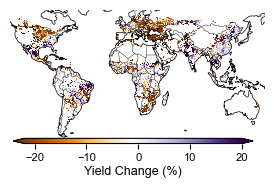

mai ssp585 -5.860366894969797


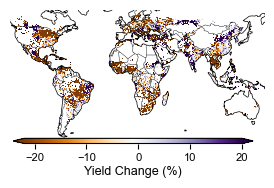

soy ssp126 -8.567911177335535


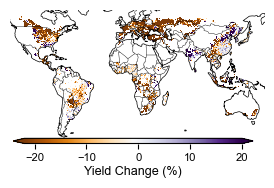

soy ssp585 -15.700216860555678


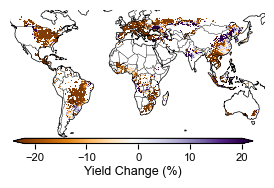

whe ssp126 -5.736274030155662


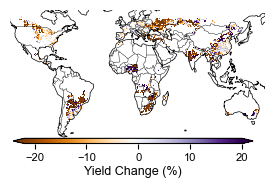

whe ssp585 -7.54636468431816


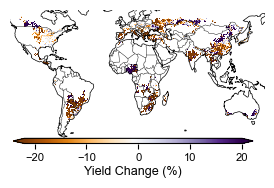

In [6]:
import xarray as xr
import numpy as np

for crop in crops:
    for future_ssp in ['ssp126', 'ssp585']:
        diff = crop_prob_dict[future_ssp][crop] - crop_prob_dict['historical'][crop]
        vmax_diff = np.nanmax(np.abs(diff.values))
        diff=diff.where(diff!=0)
        print(crop,future_ssp,diff.median().values)
        plot_fig(diff, -20, 20, 'PuOr', 'Yield Change (%)', 
                 save_path=rf'D:\AAUDE\paper\paper8\fig_region\{crop}_{future_ssp}_vs_historical_loss_decade.pdf')


In [98]:
diff = crop_prob_dict['ssp585']['mai'] - crop_prob_dict['historical']['mai']
diff=diff.where(abs(diff)<100)
diff.to_netcdf('sdf.nc')

mai historical -4.934597184512111 1.065271208969701e+33
soy historical -4.154910932552553 24.96862372903109
whe historical -7.293672403437552 353508833528697.2
mai ssp126 -4.724195705652933 3.8364365471437034e+32
soy ssp126 -6.122426581998681 12.03705771846435
whe ssp126 -6.979444217000101 1.1635603607356746e+18
mai ssp585 -3.395849938579516 1.5975896409583972e+29
soy ssp585 -5.013162526252788 23.40786285116403
whe ssp585 -3.324759230410704 1.8099068206276038e+23
mai ssp126 0.6996198536890113


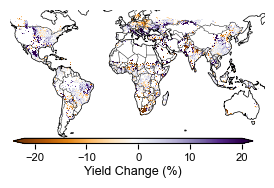

mai ssp585 1.1999039130898854


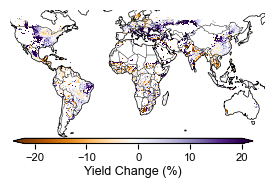

soy ssp126 -1.3872275194964439


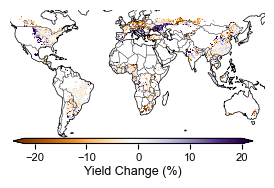

soy ssp585 -1.2505238599180521


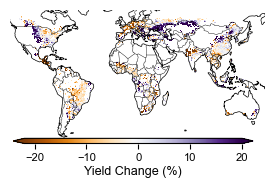

whe ssp126 -0.2825879835499576


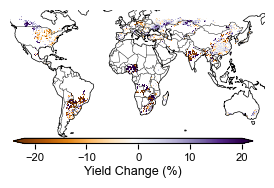

whe ssp585 1.3450312091263705


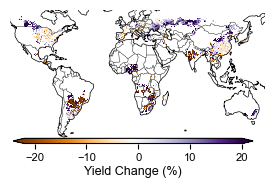

In [7]:
crop_prob_dict = {}
for ssp in ssps:
    crop_prob_dict[ssp] = {}
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-len(yied):]
        expect_yield['time']=yied.time.values
        yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ((spei < -0.5) | (ssi < -0.5))
        yield_change_drought = yield_loss.where( drought_mask).mean(dim='time')
        # yield_change_drought = yield_loss.where(drought_mask&(yield_loss<0)).mean(dim='time')
        yield_change_drought=yield_change_drought.where(yield_change_drought!=0)
        print(crop,ssp,yield_change_drought.median().values,yield_change_drought.std().values)
        # yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        crop_prob_dict[ssp][crop] = yield_change_drought
import xarray as xr
import numpy as np

for crop in crops:
    for future_ssp in ['ssp126', 'ssp585']:
        diff = crop_prob_dict[future_ssp][crop] - crop_prob_dict['historical'][crop]
        vmax_diff = np.nanmax(np.abs(diff.values))
        diff=diff.where(diff!=0)
        print(crop,future_ssp,diff.median().values)
        plot_fig(diff, -20, 20, 'PuOr', 'Yield Change (%)', 
                 save_path=rf'D:\AAUDE\paper\paper8\fig_region\{crop}_{future_ssp}_vs_historical_loss_mean.pdf')
